**Features a ser implementadas, por enquanto**

- Área do Polígono do receptor
- Área do Polígono do transmissor
- Quantas áreas de domínio adversária a bola do passe irá passar
- Ângulo _alpha_
- Média das distâncias mais próximas entre o receptor e as fronteiras adversárias
- Média das distâncias mais próximas entre o transmissor e as fronteiras adversárias
- Menor das distâncias mais próximas entre o transmissor e as fronteiras adversárias
- Menor das distâncias mais próximas entre o receptor e as fronteiras adversárias
- Proporção da área de regiões adversárias / amigas na faixa de possíveis passes definidos por _alpha_



In [58]:
#!pip install matplotsoccer

In [59]:
import numpy as np
import pandas as pd
#import matplotsoccer
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.spatial
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry import box as Box
from shapely.plotting import plot_polygon, plot_line, plot_points

In [60]:
interception_events = pd.read_csv("interception_events.csv", index_col=0).reset_index(drop=True)
interception_events.head()

,game_id,game_event_id,possession_event_type,formatted_game_clock,start_time,end_time,duration,inserted_at,updated_at,start_frame,...,21_vy,21_vtot,21_ax,21_ay,21_atot,home_ball,ball_visibility,ball_x,ball_y,ball_z
0,4438,4435777,PA,00:00,148.300,148.300,0.0,2022-08-06 17:07:20,2022-08-07 01:31:28,4389,...,-0.75,1.060660,0.000000e+00,0.000000e+00,0.000000e+00,0.0,ESTIMATED,-2.135,1.725,0.30
1,4438,4435792,PA,00:02,151.233,151.233,0.0,2022-08-06 17:08:25,2022-08-07 01:31:28,4477,...,-0.33,0.632851,-1.598721e-12,-9.000000e-01,9.000000e-01,0.0,VISIBLE,-21.122,3.604,0.00
2,4438,4435795,PA,00:07,155.667,155.667,0.0,2022-08-06 17:08:39,2022-08-07 01:31:28,4610,...,-1.92,3.003748,1.800000e+00,0.000000e+00,1.800000e+00,0.0,VISIBLE,-8.428,-27.775,0.58
3,4438,4435805,PA,00:19,167.633,167.633,0.0,2022-08-06 17:09:04,2022-08-07 01:31:28,4969,...,0.39,0.926121,1.800000e+00,-7.993606e-13,1.800000e+00,1.0,ESTIMATED,48.219,1.006,0.82
4,4438,4435817,PA,00:21,170.033,170.033,0.0,2022-08-06 17:09:34,2022-08-07 01:31:28,5041,...,0.45,1.114854,1.598721e-12,0.000000e+00,1.598721e-12,1.0,VISIBLE,46.345,-12.923,0.00


## Montando voronoi limitado

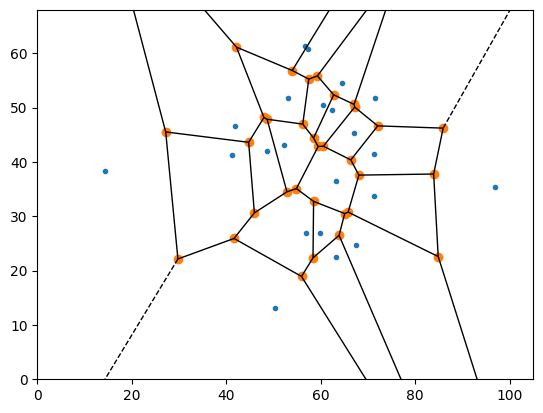

In [61]:
# Plotando um diagrama de voronoi aleatório
from scipy.spatial import Voronoi, voronoi_plot_2d

instance_index = np.random.randint(0, len(interception_events))

row = interception_events.loc[10, :]

cols_x = [str(i)+"_x" for i in range(22)]
cols_y = [str(i)+"_y" for i in range(22)]

points = np.column_stack([(row[cols_x] + 52.5).values, (row[cols_y] + 34).values])

vor = Voronoi(points)

fig = voronoi_plot_2d(vor)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

In [62]:
#https://github.com/rougier/spatial-computation/blob/master/voronoi.py

def in_box(points, bbox):
    return np.logical_and(
        np.logical_and(bbox[0] <= points[:, 0], points[:, 0] <= bbox[1]),
        np.logical_and(bbox[2] <= points[:, 1], points[:, 1] <= bbox[3]))

def voronoi(points, bbox):
    # See http://stackoverflow.com/questions/28665491/...
    #   ...getting-a-bounded-polygon-coordinates-from-voronoi-cells
    # See also https://gist.github.com/pv/8036995

    # Select points inside the bounding box
    i = in_box(points, bbox)

    # Mirror points
    points_center = points[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bbox[0] - (points_left[:, 0] - bbox[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bbox[1] + (bbox[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bbox[2] - (points_down[:, 1] - bbox[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bbox[3] + (bbox[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left, points_right, axis=0),
                                 np.append(points_down, points_up, axis=0),
                                 axis=0), axis=0)
    # Compute Voronoi
    vor = scipy.spatial.Voronoi(points)

    # Filter regions
    epsilon = 0.1
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bbox[0]-epsilon <= x <= bbox[1]+epsilon and
                       bbox[2]-epsilon <= y <= bbox[3]+epsilon):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

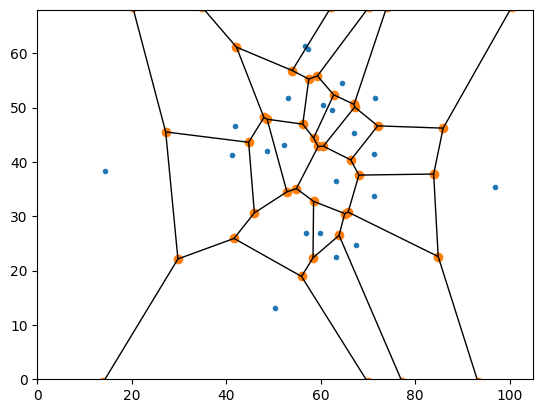

In [63]:
bounding_box = [-0.5, 105.5, -0.5, 68.5]
x = voronoi(points, bounding_box)
fig = voronoi_plot_2d(x)
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

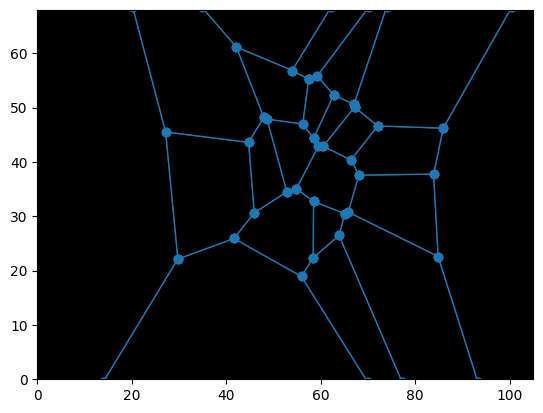

In [64]:
fig,ax = plt.subplots()

polygons = []
for region in x.filtered_regions:
  polygons.append(Polygon(x.vertices[region]))

for region in polygons:
  #print(new_vertices[region])
  plot_polygon(region, ax=ax, facecolor='k', linewidth=1)

plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

## Features

### Area

In [65]:
def feature_1_2(areas, passes, receiver):
  """
  Calcula a area do poligono do passador e do receptor
  Parameters:
  points: array de pontos
  polygons: array de poligonos
  passes: indice do passador
  receiver: indice do receptor
  """

  # retorna area do passador e do receptor
  return areas[passes], areas[receiver]

### Quantas áreas de domínio adversária a bola do passe irá passar

In [66]:
def feature_3(points, polygons, passes, receives):
    """
    Calcula a quantidade de poligonos adversarios que interceptam a linha entre o passador e o receptor
    Parameters:
    points: array de pontos
    polygons: array de poligonos
    passes: indice do passador
    receiver: indice do receptor
    """


    passe_x = [points[passes,0], points[receives,0]]
    passe_y = [points[passes,1], points[receives,1]]
    linha = LineString([[passe_x[0],passe_y[0]], [passe_x[1],passe_y[1]]])

    poligonosss = []
    if passes > 10:
      for i in range(0,11):
        poligonosss.append(Polygon(polygons[i]))
    else:
      for i in range(11,22):
        poligonosss.append(Polygon(polygons[i]))

    contagem = sum(1 for poligono in poligonosss if linha.intersects(poligono))
    return contagem

### Angulo alpha

In [67]:
def feature_4(points, polygons, passes, receives):
  """
  Calcula o angulo entre a linha do passe e as linhas tangentes ao poligono do receptor
  Parameters:
  points: array de pontos
  polygons: array de poligonos
  passes: indice do passador
  receiver: indice do receptor
  """
  def calcular_angulo(A, B, C, D):
    # Vetores
    AB = (B[0] - A[0], B[1] - A[1])
    CD = (D[0] - C[0], D[1] - C[1])
    
    # Produto escalar
    produto_escalar = AB[0] * CD[0] + AB[1] * CD[1]
    
    # Magnitudes dos vetores
    magnitude_AB = math.sqrt(AB[0]**2 + AB[1]**2)
    magnitude_CD = math.sqrt(CD[0]**2 + CD[1]**2)
    
    # Cálculo do ângulo em radianos
    angulo_radianos = math.acos(produto_escalar / (magnitude_AB * magnitude_CD))
    
    # Convertendo para graus
    angulo_graus = math.degrees(angulo_radianos)
    return angulo_graus if angulo_graus <= 90 else 180 - angulo_graus
    
  # Função para estender uma linha
  def extend_line(line, distance):
      # Pega os pontos da linha
      coords = list(line.coords)

      # Calcular o vetor de direção para o início e fim
      start_direction = np.array(coords[1]) - np.array(coords[0])
      end_direction = np.array(coords[-1]) - np.array(coords[-2])

      # Normalizar os vetores
      start_direction /= np.linalg.norm(start_direction)
      end_direction /= np.linalg.norm(end_direction)

      # Calcular os novos pontos
      new_start = np.array(coords[0]) - start_direction * distance
      new_end = np.array(coords[-1]) + end_direction * distance

      # Criar uma nova LineString com os pontos estendidos
      new_coords = [tuple(new_start)] + coords + [tuple(new_end)]
      extended_line = LineString(new_coords)

      return extended_line

  passe_x = [points[passes,0], points[receives,0]]
  passe_y = [points[passes,1], points[receives,1]]
  receiver_area = polygons[receives]
  alpha = 0
  pontos = []
  for point in receiver_area.exterior.coords[:-1]:
    #criar a linha
    linha = LineString([[passe_x[0], passe_y[0]], [point[0],point[1]]])
    #extender a linha
    linha_ext = extend_line(linha, 1000)
    if receiver_area.touches(linha_ext):
      angle = calcular_angulo([passe_x[0],passe_y[0]], [passe_x[1],passe_y[1]], [passe_x[0],passe_y[0]], [point[0],point[1]])
      #print(angle)
      alpha += angle
      pontos.append(point)
  return alpha,pontos

### Features 5 a 8

In [68]:
def features_5to8(row, polygons, player_category, operation):
    def PointInPolygon(point, polygon):
        point = Point(point)
        poly = Polygon(polygon)
        return poly.contains(point)

    def FindIntersection(player_coords, opponent_coords, opponent_voronoi):
        line = LineString([player_coords, opponent_coords])
        if opponent_voronoi != [] and line.intersects(opponent_voronoi):
            return line.intersection(opponent_voronoi)
        return None
        
    def Distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    player_number = 0
    player = {'player_id': 0, 'player_number': 0, 'opponents_players_numbers': []}
    for i in range(22):
        if row[f'{i}_player_id'] == row[player_category]:
            player_number = i
            opponents = []
        if (int(player_number) < 11): 
            opponents = [str(i) for i in range(11, 22)]
        else:
            opponents = [str(i) for i in range(11)]
        player_id = row.loc[f'{player_number}_player_id']
        player = {'player_id': player_id, 'player_number': player_number, 'opponents_players_numbers': opponents}

    coords = []
    for region in polygons:
        points_x, points_y = region.exterior.coords.xy
        x = list(points_x)
        y = list(points_y)
        coords.append((x, y))

    opponents_voronoi = {}
    for opponent in player['opponents_players_numbers']:
        opponents_voronoi[int(opponent)] = []
    for coord in coords:
        x, y = coord
        curr_poly = []
        for i in range(len(x)):
            curr_poly.append((x[i], y[i]))
        for opponent in player['opponents_players_numbers']:
            if (PointInPolygon(points[int(opponent)], curr_poly)):
                opponents_voronoi[int(opponent)] = curr_poly
                break

    borders = []
    for opponent in player['opponents_players_numbers']:
        player_coords = (points[int(player['player_number']),0], points[int(player['player_number']),1])
        opponent_coords = (points[int(opponent),0], points[int(opponent),1])
        opponent_voronoi = opponents_voronoi[int(opponent)]
        intersections = FindIntersection(player_coords, opponent_coords, Polygon(opponent_voronoi))
        if intersections:
            x_coords, y_coords = intersections.xy
            borders.append((x_coords[0], y_coords[0]))

    distances = []
    for border in borders:
        distances.append(Distance(player_coords, border))

    if operation == 0:
        return np.mean(distances)
    elif operation == 1:
        return np.min(distances)

In [69]:
print(features_5to8(row, polygons, 'target_player', 0))
print(features_5to8(row, polygons, 'passer_player', 0))
print(features_5to8(row, polygons, 'passer_player', 1))
print(features_5to8(row, polygons, 'target_player', 1))

15.23766290379187
8.451045502006833
2.8872463092019
3.7275300132929905


### Feature 9

In [70]:
def feature_9(points, polygons, passes, receives):
  """
  Calcula a razão entre a area triangulo da bola que é coberta por adversarios e a area total do poligono
  Parameters:
  points: array de pontos
  polygons: array de poligonos
  passes: indice do passador
  receiver: indice do receptor
  """

  _, pontos = feature_4(points, polygons, passes, receives)
  point_receiver = points[passes]


  #criar um triangulo com o jogador passador e os pontos
  triangulo = Polygon([tuple(point_receiver)] + pontos)
  #plot_polygon(triangulo, facecolor='black', linewidth=1)
  adversarios = []
  aliados = []

  if passes > 10:
    for i in range(0,11):
      adversarios.append(polygons[i])
    for i in range(11,22):
      aliados.append(polygons[i])
  else:
    for i in range(11,22):
      adversarios.append(polygons[i])
    for i in range(0,11):
      aliados.append(polygons[i])

  area_aliada = 0
  area_adversario = 0

  for adversario in adversarios:
    #plot_polygon(adversario, facecolor='gray', linewidth=1)
    intersection = triangulo.intersection(adversario)
    if intersection.geom_type == 'LineString':
      #plot_line(intersection, linewidth=1, color='r')
      break
    if not intersection.is_empty and (intersection.geom_type =='Polygon'):
      # print(intersection.area)
      area_adversario += intersection.area
      # plot_polygon(intersection, facecolor='r', alpha=0.5, linewidth=1)

  for aliado in aliados:
    intersection = triangulo.intersection(aliado)
    if not intersection.is_empty and (intersection.geom_type == 'Polygon'):
      #print(intersection.area)
      area_aliada += intersection.area
      # plot_polygon(intersection, facecolor='b', alpha=0.5, linewidth=1)

  # plt.xlim(0, 105)
  # plt.ylim(0, 68)
  # plt.show()
  return area_adversario / (area_adversario + area_aliada)


In [71]:
def feature_10(points, polygons, passes, receives):
  """
  Calcula a razão entre a area triangulo da bola que é coberta por adversarios e a area total do poligono
  Parameters:
  points: array de pontos
  polygons: array de poligonos
  passes: indice do passador
  receiver: indice do receptor
  """
  def reduce_line_proportionally(line, proportion):
      if proportion < 0 or proportion > 1:
          raise ValueError("Proportion must be between 0 and 1")

      # Pega os pontos da linha
      coords = list(line.coords)

      # Calcula o comprimento total da linha
      line_length = line.length

      # Calcula a distância a ser reduzida em cada extremidade
      reduction_distance = line_length * proportion / 2

      # Calcular o vetor de direção para o início e fim
      start_direction = np.array(coords[1]) - np.array(coords[0])
      end_direction = np.array(coords[-1]) - np.array(coords[-2])

      # Normalizar os vetores
      start_direction /= np.linalg.norm(start_direction)
      end_direction /= np.linalg.norm(end_direction)

      # Calcular os novos pontos
      new_start = np.array(coords[0]) + start_direction * reduction_distance
      new_end = np.array(coords[-1]) - end_direction * reduction_distance

      # Criar uma nova LineString com os pontos reduzidos
      new_coords = [tuple(new_start)] + coords[1:-1] + [tuple(new_end)]
      reduced_line = LineString(new_coords)

      return reduced_line

  _, pontos = feature_4(points, polygons, passes, receives)
  point_receiver = points[passes]
  lado1 = LineString([ponto for ponto in pontos if ponto[0] != point_receiver[0] and ponto[1] != point_receiver[1]])
  lado1 = reduce_line_proportionally(lado1, 0.7)
  pontos = list(lado1.coords)

  #criar um triangulo com o jogador passador e os pontos
  triangulo = Polygon([tuple(point_receiver)] + pontos)
  #plot_polygon(triangulo, facecolor='gray', linewidth=1)
  adversarios = []
  aliados = []

  if passes > 10:
    for i in range(0,11):
      adversarios.append(polygons[i])
    for i in range(11,22):
      aliados.append(polygons[i])
  else:
    for i in range(11,22):
      adversarios.append(polygons[i])
    for i in range(0,11):
      aliados.append(polygons[i])

  area_aliada = 0
  area_adversario = 0

  for adversario in adversarios:
    #plot_polygon(adversario, facecolor='gray', linewidth=1)
    intersection = triangulo.intersection(adversario)
    if intersection.geom_type == 'LineString':
      #plot_line(intersection, linewidth=1, color='r')
      break
    if not intersection.is_empty and (intersection.geom_type =='Polygon'):
      # print(intersection.area)
      area_adversario += intersection.area
      # plot_polygon(intersection, facecolor='r', alpha=0.5, linewidth=1)

  for aliado in aliados:
    intersection = triangulo.intersection(aliado)
    if not intersection.is_empty and (intersection.geom_type == 'Polygon'):
      #print(intersection.area)
      area_aliada += intersection.area
      # plot_polygon(intersection, facecolor='b', alpha=0.5, linewidth=1)

  # plt.xlim(0, 105)
  # plt.ylim(0, 68)
  # plt.show()
  return area_adversario / (area_adversario + area_aliada)


In [72]:
def calc_areas(polygons, points):
    areas = []
    controle = [-1]*len(points)
    for i, player in enumerate(points):
        for j,region in enumerate(polygons):
            player = Point(player)
            if controle[i] == -1 and region.contains(player):
                aux = Polygon(region)
                areas += [aux.area]
                controle[i] = j
                break
    return areas, controle

def get_passer_receiver(row):
    receives = -1
    passes = -1
    for i in range(22):
        if row[f'{i}_player_id'] == row['target_player']:
            receives = i
        if row[f'{i}_player_id'] == row['passer_player']:
            passes = i
    return passes, receives

In [73]:
def cria_features(row):
  cols_x = [str(i)+"_x" for i in range(22)]
  cols_y = [str(i)+"_y" for i in range(22)]

  points = np.column_stack([(row[cols_x] + 52.5).values, (row[cols_y] + 34).values])

  bounding_box = [-0.5, 105.5, -0.5, 68.5]
  x = voronoi(points, bounding_box)
  polygons = []
  for region in x.filtered_regions:
    polygons.append(Polygon(x.vertices[region]))

  areas, controle = calc_areas(polygons, x.filtered_points)
  polygons = [polygons[i] for i in controle]

  passes, receives = get_passer_receiver(row)

  f1,f2 = feature_1_2(areas, passes, receives)
  f3 = feature_3(points, polygons, passes, receives)
  f4, _ = feature_4(points, polygons, passes, receives)
  f5 = features_5to8(row, polygons, 'target_player', 0)
  f6 = features_5to8(row, polygons, 'passer_player', 0)
  f7 = features_5to8(row, polygons, 'passer_player', 1)
  f8 = features_5to8(row, polygons, 'target_player', 1)
  f9 = feature_9(points, polygons, passes, receives)
  f10 = feature_10(points, polygons, passes, receives)

  return f1, f2, f3, f4, f5, f6, f7, f8, f9, f10

In [77]:
from tqdm import tqdm

aux = []

columns = ['instance_index',
           'receiver_polygon_area',
           'transmitter_polygon_area',
           'adversary_domain_pass_count',
           'alpha_angle',
           'avg_distance_receiver_adversary_boundaries',
           'avg_distance_transmitter_adversary_boundaries',
           'min_distance_transmitter_adversary_boundaries',
           'min_distance_receiver_adversary_boundaries',
           'adversary_friend_area_ratio',
           'adversary_friend_area_ratio_reduced']

for instance_index in tqdm(range(len(interception_events[:100]))):
  row = interception_events.loc[instance_index, :]
  try:
    f1, f2, f3, f4, f5, f6, f7, f8, f9, f10 = cria_features(row)
    aux += [[instance_index,f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]]
  except Exception as e:
    print(e)
    print(f"Erro na instancia {instance_index}")

df = pd.DataFrame(aux, columns=columns)
df

100%|██████████| 100/100 [00:04<00:00, 21.01it/s]


,instance_index,receiver_polygon_area,transmitter_polygon_area,adversary_domain_pass_count,alpha_angle,avg_distance_receiver_adversary_boundaries,avg_distance_transmitter_adversary_boundaries,min_distance_transmitter_adversary_boundaries,min_distance_receiver_adversary_boundaries,adversary_friend_area_ratio,adversary_friend_area_ratio_reduced
0,0,63.387090,242.767714,0,48.156930,19.991699,8.411273,0.000000,5.622250,0.024118,0.000449
1,1,328.830275,408.025340,0,58.704612,24.081183,22.125878,3.410451,11.503875,0.018736,0.000000
2,2,254.831618,70.313232,2,17.323893,8.791049,29.406569,15.301163,0.000000,0.544893,0.481678
3,3,184.194074,150.526507,0,65.250709,17.360676,39.881190,22.943427,0.000000,0.047695,0.000000
4,4,129.126380,81.344942,1,43.009257,10.037803,18.182024,2.619260,1.236837,0.301728,0.073614
...,...,...,...,...,...,...,...,...,...,...,...
95,95,360.671238,30.313301,3,17.535938,16.101758,22.461688,0.000000,0.000000,0.908590,0.941298
96,96,36.374824,24.325225,1,39.129120,19.926153,15.502960,7.035726,8.460161,0.635087,0.726420
97,97,21.960840,75.610835,1,58.362980,14.738443,19.667127,8.210673,0.000000,0.670684,0.572932
98,98,78.345796,103.618742,2,46.045633,14.817548,15.078674,0.000000,0.000000,0.547089,0.617696


In [75]:
#df.to_csv('features.csv')

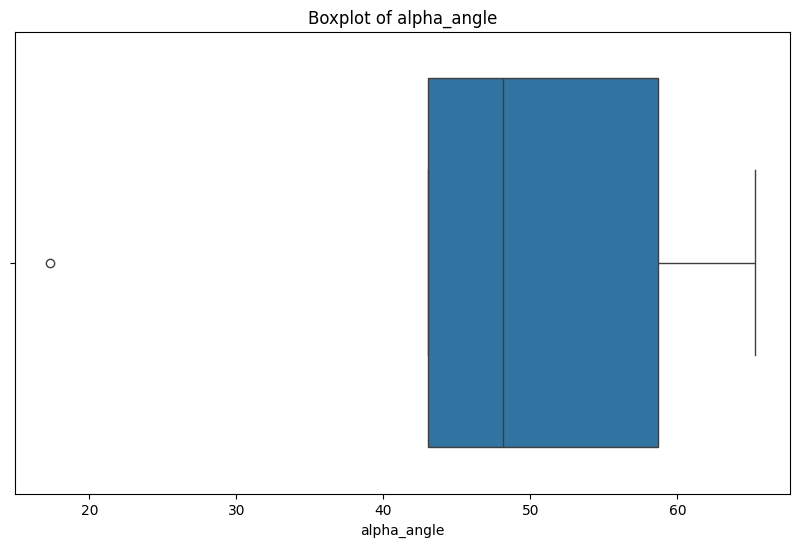

In [76]:
import seaborn as sns
column_to_plot = 'alpha_angle'

# Criar o boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df[column_to_plot])

# Adicionar título e rótulos
plt.title(f'Boxplot of {column_to_plot}')
plt.xlabel(column_to_plot)

# Mostrar o gráfico
plt.show()